In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

# Чтение изображений
Есть много способов прочитать изображение. Вот некоторые библиотеки:
* ImageIO
* Pillow
* OpenCV

Многие библиотеки для высокоуровневой работы с изображениями (Matplotlib, scikit-image) также предоставляют функционал для чтения, но он чаще всего опирается на Pillow или OpenCV.


In [3]:
filepath = 'sample.jpg'

## ImageIO
Простейшая библиотека, заточенная исключительно на чтение и запись. Предоставляет удобный интерфейс для обращения к Pillow, OpenCV или другим плагинам, если они установлены. Сразу преобразовывает в numpy.ndarray.

In [16]:
import imageio.v3 as imageio

img = imageio.imread(filepath)
print(f'{type(img) = }')
print(f'{img.shape = }')
print(f'{img.dtype = }')


type(img) = <class 'numpy.ndarray'>
img.shape = (955, 1280, 3)
img.dtype = dtype('uint8')


Может показаться, что 3 канала и uint8 &mdash; это инварианты, но это не так.

Для вывода картинки прямо в Jupyter Notebook удобно использовать Matplotlib.

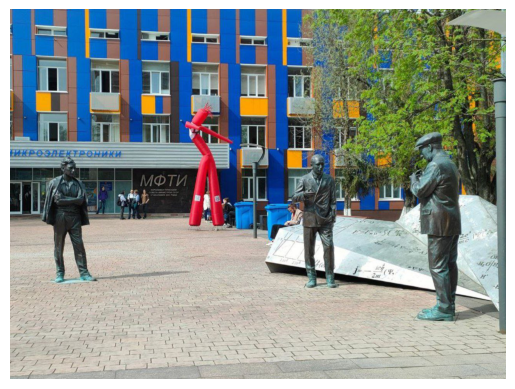

In [12]:
plt.imshow(img)
plt.axis('off')
plt.show()


Запись в файл с автоматическим определением формата.

In [41]:
imageio.imwrite('sample_copy.jpg', img)

ImageIO не поймёт, как сохранять массив типа отличного от uint8.

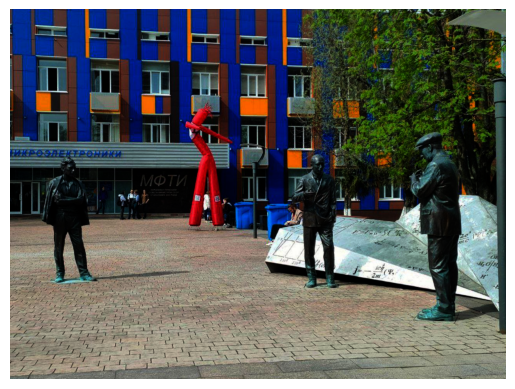

Ошибка!


In [71]:
# Допустим, мы захотели сделать гамма-коррекцию.
img_float = img / 255  # Опасная строчка, скоро объясню почему
img_float **= 2.2
plt.imshow(img_float)
plt.axis('off')
plt.show()  # Matplotlib справится с float
try:
    imageio.imwrite('sample_copy.jpg', img_float)
except Exception as _:
    print('Ошибка!', file=sys.stderr)

# Специально для ImageIO значения надо приводить к uint8.
img_uint8 = (img_float * 255).astype(np.uint8)
imageio.imwrite('sample_copy.jpg', img_uint8)


## Pillow
При чтении возвращает объект своего особенного типа (не numpy.ndarray).

In [50]:
from PIL import Image

img_pil = Image.open(filepath)
type(img_pil)

PIL.JpegImagePlugin.JpegImageFile

Этот тип можно использовать для вывода в Jupyter Notebook **без потери качества**.

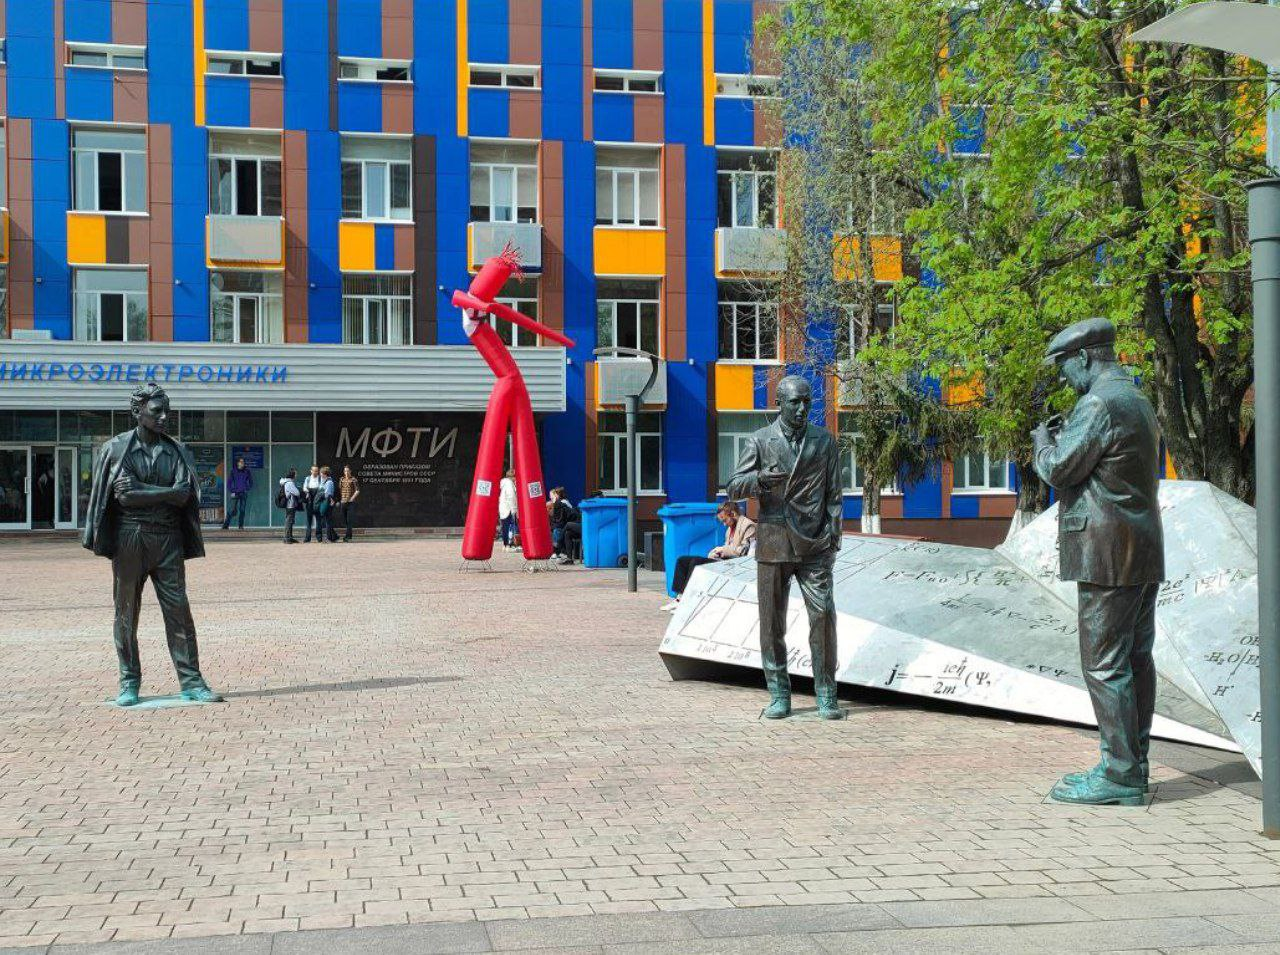

In [51]:
img_pil

Если картинка изначально была в виде numpy-массива, можно привести её к PIL-типу.

In [66]:
img_np = np.zeros((100, 100, 3), dtype=np.uint8)
img_pil = Image.fromarray(img_np)
type(img_pil)

PIL.Image.Image

**Предостережение.** При выводе на экран в Jupyter такая картинка сериализуется в PNG-формат, что в случае с фотографиями **может сильно раздуть вес файла ноутбука**.

Чтобы вывести numpy.ndarray в виде JPEG, придётся постараться.

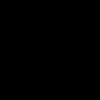

In [65]:
from IPython.display import display, Image as IPyImage
from io import BytesIO

# Сохраняем картинку в буфер, а не в файл.
buffer = BytesIO()
img_pil.save(buffer, format='JPEG')
img_bytes = buffer.getvalue()

display(IPyImage(data=img_bytes, format='jpeg'))

## OpenCV
Как мометально выстрелить себе в ногу

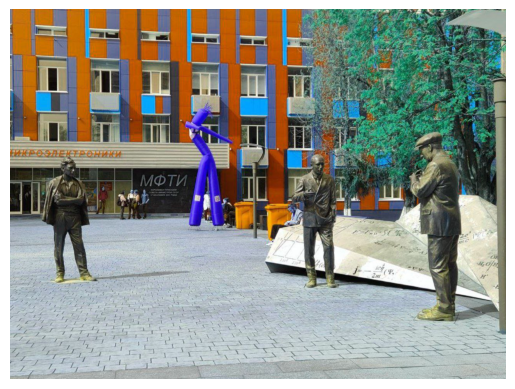

In [68]:
import cv2

img = cv2.imread(filepath)
plt.imshow(img)
plt.axis('off')
plt.show()

Что произошло? OpenCV использует конвенцию BGR вместо RGB.

Для перестановки каналов надо воспользоваться отдельной функцией

In [73]:
img = cv2.imread(filepath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

### **Сравнение**:

|  | ImageIO | Pillow | OpenCV (`cv2`) |
| --- | --- | --- | --- |
| **Простота использования** | Легко | Легко | Средне |
| **Поддержка форматов** | Очень широкая | Широкая | Широкая |
| **Скорость** | Умеренная | Умеренная | Высокая (C++) |
| **Image Processing** | Отсутствует | Ограниченный | Расширенный (Computer Vision) |


# Чтение метаинформации изображений

Exif &mdash; единый стандарт для хранения метаинформации в изображениях. Наиболее полного чтения можно достичь с использованием консольной утилиты `exiftool`. Для Питона есть обёртка `pyexiftool`.

In [75]:
import exiftool

with exiftool.ExifToolHelper() as et:
    metadata = et.get_metadata('Shoes-sRGB.jpg')
for key in metadata[0]:  # Индексация - на случай, если передали несколько файлов
    print(key, '=', metadata[0][key])

SourceFile = Shoes-sRGB.jpg
ExifTool:ExifToolVersion = 12.97
File:FileName = Shoes-sRGB.jpg
File:Directory = .
File:FileSize = 451785
File:FileModifyDate = 2024:10:07 05:12:07+03:00
File:FileAccessDate = 2024:10:07 05:13:31+03:00
File:FileInodeChangeDate = 2024:10:07 05:12:07+03:00
File:FilePermissions = 100664
File:FileType = JPEG
File:FileTypeExtension = JPG
File:MIMEType = image/jpeg
File:ExifByteOrder = MM
File:CurrentIPTCDigest = d41d8cd98f00b204e9800998ecf8427e
File:ImageWidth = 600
File:ImageHeight = 400
File:EncodingProcess = 0
File:BitsPerSample = 8
File:ColorComponents = 3
File:YCbCrSubSampling = 1 1
JFIF:JFIFVersion = 1 1
JFIF:ResolutionUnit = 0
JFIF:XResolution = 72
JFIF:YResolution = 72
EXIF:Orientation = 1
EXIF:XResolution = 72
EXIF:YResolution = 72
EXIF:ResolutionUnit = 2
EXIF:ColorSpace = 1
EXIF:ExifImageWidth = 600
EXIF:ExifImageHeight = 400
Photoshop:IPTCDigest = d41d8cd98f00b204e9800998ecf8427e
Composite:ImageSize = 600 400
Composite:Megapixels = 0.24


## Цветовые профили

In [4]:
import colour

Наибольший интерес для нас представляет информация о цветовом пространстве. Вспомним, что они из себя представляют.

Самым коротким образом числовое описания цвета вводится так. Если спектр источника излучения равен задаётся функцией $s(\lambda)$, субъективные зрительные ощущения однозначно описываются тремя числами:

$$
X = \int_0^{+\infty} s(\lambda) \bar{x}(\lambda) d\lambda\\
Y = \int_0^{+\infty} s(\lambda) \bar{y}(\lambda) d\lambda\\
Z = \int_0^{+\infty} s(\lambda) \bar{z}(\lambda) d\lambda,
$$

где функции $\bar{x}(\lambda)$, $\bar{y}(\lambda)$ и $\bar{z}(\lambda)$ известны:

/home/cromtus/tmp/seminar/.venv/lib/python3.11/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: The "CIE 2012 2 Degree Standard Observer" has been renamed to "CIE 2015 2 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028
/home/cromtus/tmp/seminar/.venv/lib/python3.11/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: The "CIE 2012 10 Degree Standard Observer" has been renamed to "CIE 2015 10 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028


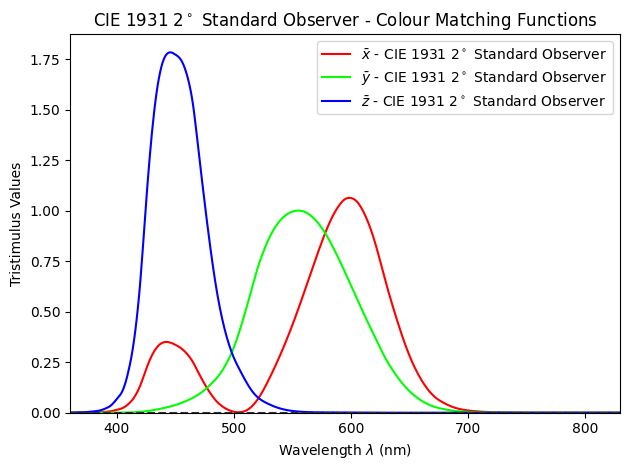

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'CIE 1931 2$^\\circ$ Standard Observer - Colour Matching Functions'}, xlabel='Wavelength $\\lambda$ (nm)', ylabel='Tristimulus Values'>)

In [5]:
xyz_cmfs = colour.MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
colour.plotting.plot_single_cmfs(xyz_cmfs)

Всевозможные спектры $s(\lambda)$ определяют геометрическое место точек $(X, Y, Z)$.

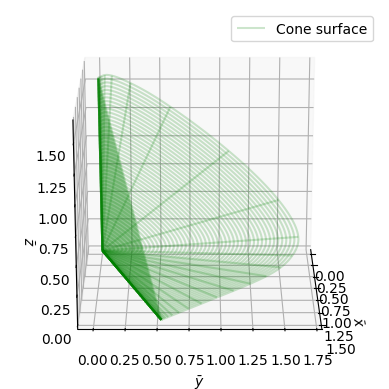

In [11]:
ax = plt.figure().add_subplot(projection='3d')

normalized_locus = xyz_cmfs.values.T / xyz_cmfs.values.sum(axis=1)
normalized_locus = np.concatenate((normalized_locus, normalized_locus[:, :1]), axis=1) # closing
surface = normalized_locus[..., np.newaxis] * np.linspace(0, 2)

ax.plot_wireframe(*surface, label='Cone surface', color='g', alpha=0.2)

ax.legend()
ax.view_init(elev=20., azim=0)
ax.set_aspect('equal')
ax.set_xlabel('$\\bar{x}$')
ax.set_ylabel('$\\bar{y}$')
ax.set_zlabel('$\\bar{z}$')
plt.show()

Заметим, что цвета $(X, Y, Z)$ и $\alpha(X, Y, Z)$ отличаются только яркостью. Поэтому удобно смотреть на _диаграмму цветности_, на которой координаты нормализованы так, что $X + Y + Z = 1$.



/home/cromtus/tmp/seminar/.venv/lib/python3.11/site-packages/colour/utilities/verbose.py:265: ColourUsageWarning: The "ALEXA Wide Gamut" RGB colourspace has been renamed to "ARRI Wide Gamut 3" for consistency with ARRI's new naming convention.
  warn(*args, **kwargs)  # noqa: B028


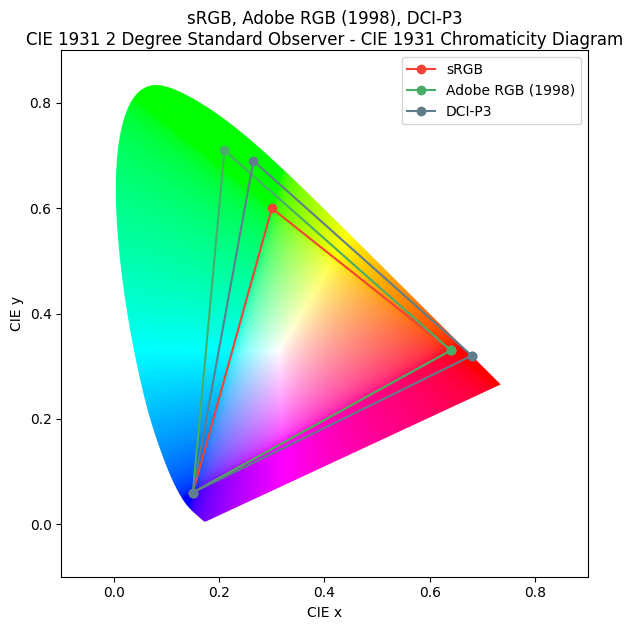

(<Figure size 640x640 with 1 Axes>,
 <Axes: title={'center': 'sRGB, Adobe RGB (1998), DCI-P3\nCIE 1931 2 Degree Standard Observer - CIE 1931 Chromaticity Diagram'}, xlabel='CIE x', ylabel='CIE y'>)

In [14]:
colour.plotting.plot_RGB_colourspaces_in_chromaticity_diagram_CIE1931(
    ['sRGB', 'Adobe RGB (1998)', 'DCI-P3'],
    show_whitepoints=False,
    show_spectral_locus=False,
)

Устройства отображения цвета (мониторы) имеют светодиоды трёх цветов, которые светятся с разной интенсивностью. Регулируя интенсивности, можно получить любой цвет, _лежащий в пределах трёхгранного конуса_, образованного первичными цветами. На диаграмме цветности это ограничение выглядит треугольником.

Trade-off: широкий цветовой охват vs. высокая стоимость светодиодов.

Чтобы говорить о цветовых координатах, надо определиться с _базисом_, в котором мы их задаём.

Как правило, подразумевается sRGB.

Но важно помнить о существовании других цветовых профилей.

### Пример

In [76]:
img_adobe_rgb = imageio.imread('Shoes-AdobeRGB.jpg')
img_srgb = imageio.imread('Shoes-sRGB.jpg')
np.any(img_adobe_rgb != img_srgb)

np.True_

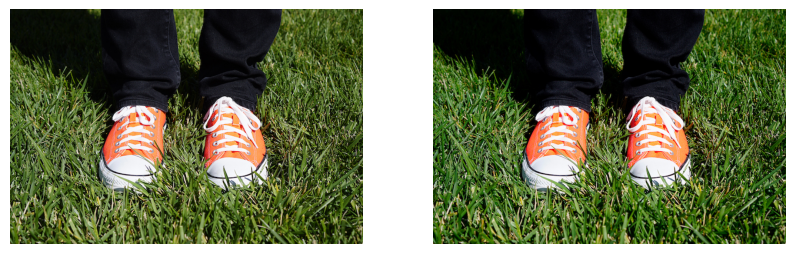

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(img_adobe_rgb)
ax[0].axis('off')
ax[1].imshow(img_srgb)
ax[1].axis('off')
plt.show()

Что произошло?
1. Мы импортировали две картинки с одинаковыми цветами, но заданными в разных цветовых пространствах.
2. Matplotlib в обоих случаях проинтерпретировал координаты как sRGB.

Из-за похожего механизма безобидная на первый взгляд операция чтения картинки и записи без изменений на самом деле может приводить к изменениям.

In [59]:
img_adobe_rgb = imageio.imread('Shoes-AdobeRGB.jpg')
imageio.imwrite('Shoes-AdobeRGB-copy.jpg', img_adobe_rgb)

Как же тогда правильно? Вот так:

In [63]:
img_adobe_rgb = imageio.imread('Shoes-AdobeRGB.jpg')
icc_profile = imageio.immeta('Shoes-AdobeRGB.jpg')['icc_profile']
imageio.imwrite('Shoes-AdobeRGB-copy.png', img_adobe_rgb, icc_profile=icc_profile)

На практике _маловероятно_, что вам попадётся картинка в цветовом профиле отличном от sRGB.

Популярность sRGB связана с тем, что это стандарт, который поддерживается большинством устройств. Чтобы узнать, поддерживает ли ваш монитор более широкие цветовые профили, можно посетить [эту замечательную страничку](https://webkit.org/blog-files/color-gamut/).

## Битность цвета

Используете паттерн `imageio.imread(filepath) / 255`? Будьте осторожны.

In [20]:
with exiftool.ExifToolHelper() as et:
    metadata = et.get_metadata('fake_and_real_peppers_ms_16.png')
print(metadata[0]['PNG:BitDepth'])

16


Монохромные PNG могут иметь до 16 бит на канал, т. е. значения прочитанного массива могут лежать в диапазоне от 0 до 65535.

In [23]:
imageio.imread('fake_and_real_peppers_ms_16.png').max()

61843

Универсальный способ нормализации:
```python
img = imageio.imread('example.png')
img = img / np.iinfo(img.dtype).max
```


# Конвейер обработки изображений на коленке
RAW-изображения &mdash; сырые изображения камеры, не подвергшиеся конвейеру обработки.

Для работы с ними есть библиотека `rawpy`.

In [30]:
import rawpy

raw = rawpy.imread('IMG_7842.cr2')
print(f'{raw.raw_type = }\n')
print(f'{raw.color_desc = }\n')
print(f'raw.raw_pattern =\n{raw.raw_pattern}\n')
print(f'raw.raw_colors =\n{raw.raw_colors}\n')
print(f'raw.raw_image =\n{raw.raw_image}\n')

raw.raw_type = <RawType.Flat: 0>

raw.color_desc = b'RGBG'

raw.raw_pattern =
[[0 1]
 [3 2]]

raw.raw_colors =
[[0 1 0 ..., 1 0 1]
 [3 2 3 ..., 2 3 2]
 [0 1 0 ..., 1 0 1]
 ..., 
 [3 2 3 ..., 2 3 2]
 [0 1 0 ..., 1 0 1]
 [3 2 3 ..., 2 3 2]]

raw.raw_image =
[[ 3152   919   995 ...,  9783 14474  3052]
 [  352   396   361 ...,   294   361   399]
 [  351   376   360 ...,  2054  2048  2047]
 ..., 
 [ 2054  2039  2039 ...,  5823  6642  5577]
 [ 2052  2048  2016 ...,  6795  3857  6704]
 [ 2071  2033  2052 ...,  5941  6300  5173]]



## Шаг 1. Демозаикинг
Чтобы получить, например, значения красного канала в местах, где красный канал отсутствует, применяют интерполяцию. Мы для простоты такого делать не будем, а просто уменьшим картинку в два раза: каждый участок 2х2 превратится в один пиксель

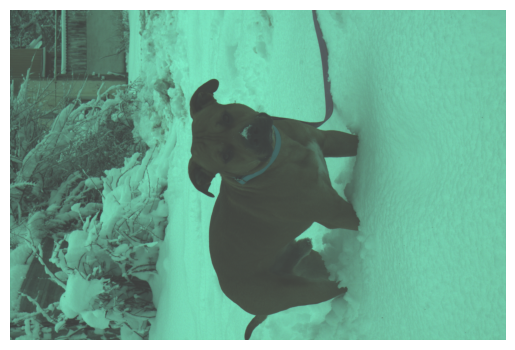

In [32]:
def flatten_bayer(img: np.ndarray):
    h, w = np.array(img.shape) // 2
    return img.reshape(h, 2, w, 2).transpose(0, 2, 1, 3).reshape(h, w, 4)
def sorting_permutation(seq):
    return list(map(
        lambda pair: pair[0],
        sorted(enumerate(seq), key=lambda pair: pair[1])
    ))

img_initial = flatten_bayer(raw.raw_image_visible)
colors_order = np.squeeze(flatten_bayer(raw.raw_pattern))
img_debayered = img_initial[..., sorting_permutation(colors_order)]

plt.imshow(img_debayered[..., :3] / img_debayered.max())
plt.axis('off')
plt.show()

## Шаг 2. Учёт темнового тока и уровня насыщения
Даже при отсутствии света матрица фотоаппарата будет регистрировать некоторый уровень сигнала, называемый _темновым током_. Также у каждого типа пикселя есть максимально возможное значение, превышение которого приводит к _насыщению_.

К счастью, данные для поправки уже есть в RAW-файле.

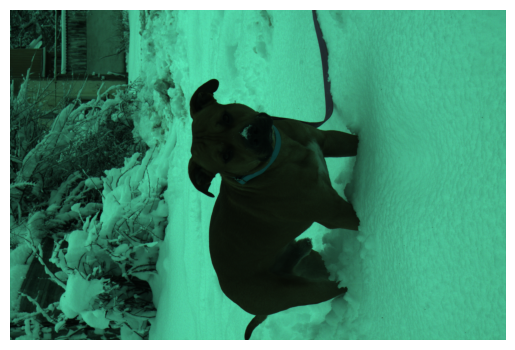

In [33]:
img_scaled = (img_debayered - raw.black_level_per_channel) /\
             (np.array(raw.camera_white_level_per_channel) - raw.black_level_per_channel)
img_scaled = np.clip(img_scaled, 0, 1)

plt.imshow(img_scaled[..., :3] / img_scaled.max())
plt.axis('off')
plt.show()

## Шаг 3. Баланс белого
В процессе съёмки камера оценивает окружающую освещённость для будущей цветокоррекции. Во-первых, это поможет отнормировать значения каналов, ибо зелёный фотодиод самый чувствительный и всегда будет давать большие значения. Во-вторых, цель фотографии &mdash; сделать максимально приятную глазу человека картинку. Зрительная система человека умеет подстраиваться под фоновое освещение, и даже при тёплом ламповом свете мы будем воспринимать лист бумаги белым. Точное же измерение цвета будет нам казаться неудовлетворительным.

Значения для настройки баланса белого хранятся в `raw.camera_whitebalance`

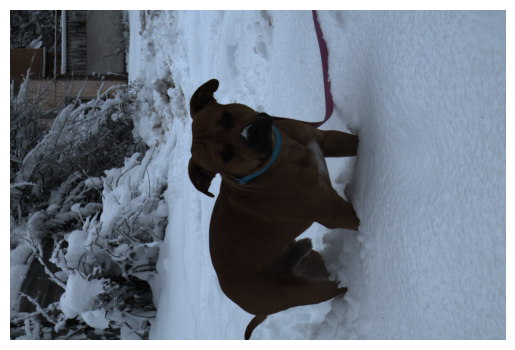

In [34]:
img_white_balanced = img_scaled * raw.camera_whitebalance / 1024

plt.imshow(img_white_balanced[..., :3] / img_white_balanced.max())
plt.axis('off')
plt.show()

## Шаг 4. Переход из цветового пространства камеры в XYZ.
Спектральные чувствительности камеры образуют своё цветовое пространство по тому же принципу, что и функции сопоставления цвета CIE XYZ. Спектры, дающие один и тот же цвет в одном пространстве, могут давать разные цвета в другом пространстве, поэтому точный переход от одного пространства к другому, вообще говоря, невозможен. Поэтому задачу подбора преобразования решают лишь приблизительно.

Матрица приблизительного перехода из XYZ в пространство камеры хранится в `raw.rgb_xyz_matrix`. Для обратного перехода понадобится обратная матрица.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0102269747007..0.552401603586].


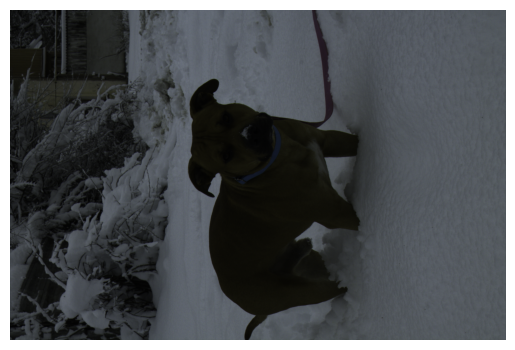

In [36]:
img_xyz = img_scaled @ np.linalg.pinv(raw.rgb_xyz_matrix).T

plt.imshow(img_xyz)
plt.axis('off')
plt.show()

## Шаг 5. Переход из XYZ в sRGB
Для отображения на мониторе нужно перейти в пространство sRGB

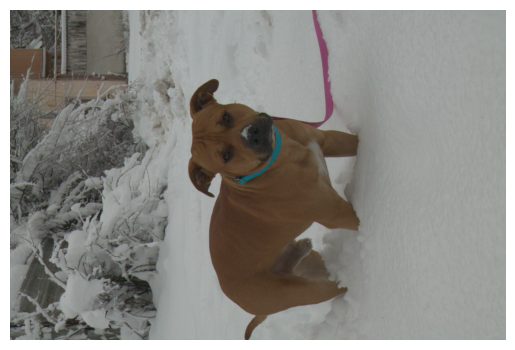

In [37]:
img_rgb = np.clip(colour.XYZ_to_sRGB(img_xyz), 0, 1)

plt.imshow(img_rgb)
plt.axis('off')
plt.show()

# Take-out messages
* Для чтения изображений достаточно библиотеки `imageio`, если вы ещё не импортировали чего-то более специфичного.
* Цветовой профиль изображения может быть нестандартным. Если это так, нужно держать в уме, что для отображения на экране нужно перейти в sRGB.
* Числа в цветовых каналах могут вылезать за пределы 0...255 в случае другой битности изображения.
* Для использования изображения в качестве физического измерения нужно выбирать RAW-формат (или попытаться как-то провернуть конвейер обработки назад).